In [13]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
from helpers import Trade
import os
import sys

plt.style.use('Solarize_Light2')

# **Loading constants needed**

In [14]:
# import json

# with open('prams.json', 'r') as file:
#     data = json.load(file)

# WINDOW, SIGNALS, LOWER_PRICE_DEVIATION, HIGHER_PRICE_DEVIATION, POSITIONS_NATURE, POSITIONS_SHORTCUT, FIGSIZE=data['WINDOW'], data['SIGNALS'], data['LOWER_PRICE_DEVIATION'], data['HIGHER_PRICE_DEVIATION'], data['POSITIONS_NATURE'], data['POSITIONS_SHORTCUT'], data['FIGSIZE']

WINDOW = 31

SIGNALS = {
    "BUY": 1,
    "SELL": -1
}

LOWER_PRICE_DEVIATION = {
    "SL": 6, 
    "ENTRY": 5, 
    "TP": 2
}

HIGHER_PRICE_DEVIATION = {
    "SL": 5, 
    "ENTRY": 4, 
    "TP": 2
}

POSITIONS_NATURE = {
    "1": "Long",
    "-1": "Short"
}

POSITIONS_SHORTCUT = {
    "1": "L",
    "-1": "H"
}

FIGSIZE = {
    "WIDTH": 20,
    "HEIGHT": 5,
    "LEN": 5
}

LOWER_RRR = (LOWER_PRICE_DEVIATION['ENTRY'] - LOWER_PRICE_DEVIATION['TP'])/(LOWER_PRICE_DEVIATION['SL'] - LOWER_PRICE_DEVIATION['ENTRY'])
HIGHER_RRR = (HIGHER_PRICE_DEVIATION['ENTRY'] - HIGHER_PRICE_DEVIATION['TP'])/(HIGHER_PRICE_DEVIATION['SL'] - HIGHER_PRICE_DEVIATION['ENTRY'])

# **1. Loading & Cleaning Data**

In [15]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    # gold_ticker = yf.Ticker("NQ=F")
    # gold_ticker = yf.Ticker("YM=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

# bool_df = df.isna()
# bool_df.loc[(bool_df['Close'] == True) | (bool_df['High'] == True) | (bool_df['Low'] == True) | (bool_df['Open'] == True)]

# display(df.shape)
# display(df.head(3))

- stop if the data is incomplete

In [16]:
bool_df = df.isna()
if not bool_df.loc[(bool_df['Close'] == True) | (bool_df['High'] == True) | (bool_df['Low'] == True) | (bool_df['Open'] == True)].empty:
    print("There is missing data")
    sys.exit("There is missing data")

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [17]:
df['Mean'] = df['Close'].rolling(window=WINDOW).mean()
# df['Mean'] = df['Close'].ewm(span=WINDOW, adjust=False).mean()
df['STD'] = df['Close'].rolling(window=WINDOW).std()
df['Z-Score'] = np.where(
    df['High'] + df['Low'] > 2 * df['Mean'],
    (df['High'] - df['Mean']) / df['STD'],
    (df['Low'] - df['Mean']) / df['STD']
)

df['Mean'] = df['Mean'].shift(1)
df['STD'] = df['STD'].shift(1)
df['Z-Score'] = df['Z-Score'].shift(1)

df.dropna(inplace=True)

df.head(5)

,Open,High,Low,Close,Mean,STD,Z-Score
Datetime,,,,,,,
2022-10-14 16:00:00+00:00,1650.300049,1654.500000,1646.699951,1649.400024,1669.283876,9.013661,-2.117222
2022-10-14 17:00:00+00:00,1649.500000,1650.900024,1646.099976,1650.800049,1668.254843,9.408393,-2.291028
2022-10-14 18:00:00+00:00,1650.900024,1650.900024,1646.800049,1647.800049,1667.277426,9.601376,-2.205668
2022-10-14 19:00:00+00:00,1647.900024,1649.300049,1645.599976,1648.800049,1666.225814,9.896928,-1.962808
2022-10-14 20:00:00+00:00,1648.699951,1650.699951,1648.400024,1650.199951,1665.045170,9.714716,-2.001623


### Overview

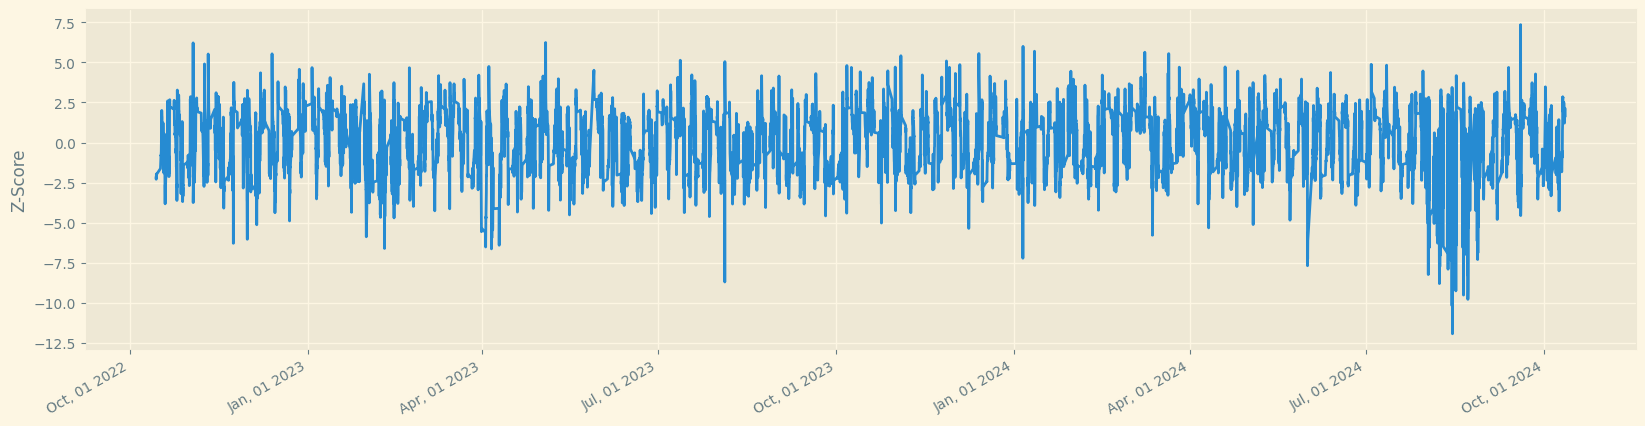

In [18]:
df['Z-Score'].plot(kind='line', xlabel='', ylabel="Z-Score", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT']))

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

,Z-Score
max,7.35204
min,-11.93028


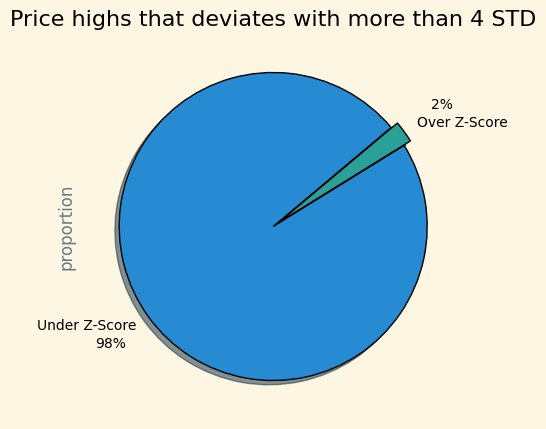

In [19]:
# stats = (abs(df['Z-Score']) > LOWER_PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)
stats = (abs(df['Z-Score']) > HIGHER_PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)

stats.index = ['Under Z-Score', 'Over Z-Score']

stats.plot(
    kind='pie', 
    figsize=(FIGSIZE['LEN'],FIGSIZE['LEN']),
    # title=f"Price lows that deviates with more than {LOWER_PRICE_DEVIATION['ENTRY']} STD",
    title=f"Price highs that deviates with more than {HIGHER_PRICE_DEVIATION['ENTRY']} STD",
    autopct='%1.0f%%',
    pctdistance=1.3,
    labeldistance=1.1,
    shadow=True,
    explode=[0, 0.05],
    wedgeprops={'edgecolor': 'black'},
    startangle=40
    # colors=["#ECDFCC", "#3C3D37"]
)

df['Z-Score'].agg(['max', 'min']).to_frame()

### Generate buy/sell signals

In [20]:
price_deviate_over_xSTD_filter = df['Z-Score'] > HIGHER_PRICE_DEVIATION['ENTRY']
price_deviate_under_xSTD_filter = df['Z-Score'] < -LOWER_PRICE_DEVIATION['ENTRY']

df['Signal'] = 0  # Default to hold/no position
df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

# **3. Implementing Stop Loss and Take Profit**

In [21]:
# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

def exit_trade(idx, is_win: bool):
    df.loc[idx, 'Exit_Price'] = trade.tp if is_win else trade.sl
    pnl = (LOWER_RRR if trade.is_buy else HIGHER_RRR) if is_win else -1
    df.loc[idx, ['PnL', 'Position']] = [pnl, SIGNALS['BUY' if trade.is_buy else 'SELL']]
    return True

def is_buy_sl(idx):
    if df.loc[idx, 'Low'] <= trade.sl: return exit_trade(idx, False)
    return False

def is_buy_tp(idx, source='High'):
    if df.loc[idx, source] > trade.tp: return exit_trade(idx, True)
    return False

def is_sell_sl(idx):
    if df.loc[idx, 'High'] >= trade.sl: return exit_trade(idx, False)
    return False

def is_sell_tp(idx, source='Low'):
    if df.loc[idx, source] < trade.tp: return exit_trade(idx, True)
    return False

# [NB] check SL first then make sure trade is On to check TP

def fill_trade_params(_row, idx):
    trade_signal = _row['Signal']

    is_long = (trade_signal == SIGNALS['BUY'])

    trade.On()
    DEVIATION =  LOWER_PRICE_DEVIATION if is_long else HIGHER_PRICE_DEVIATION
    trade.entry = (_row['Mean'] - trade_signal * DEVIATION['ENTRY'] * _row['STD'])
    trade.tp = (_row['Mean'] - trade_signal * DEVIATION['TP'] * _row['STD'])
    trade.sl = (_row['Mean'] - trade_signal * DEVIATION['SL'] * _row['STD'])
    df.loc[idx, ['Position', 'Entry_Price']] = [trade_signal, trade.entry]

    # check if sl or tp is already hit in the same candel (i)
    if is_long:
        if is_buy_sl(idx): trade.Off()
        elif is_buy_tp(idx, source='Close'): trade.Off()
    else:
        if is_sell_sl(idx): trade.Off()
        elif is_sell_tp(idx, source='Close'): trade.Off()

# Loop through candles and execute trades
for idx, row in df.iterrows(): # row for reading, i for writing
    if trade.on: 
        # Track price movement for Stop Loss or Take Profit
        if trade.is_buy: 
            if is_buy_sl(idx): trade.Off()
            elif is_buy_tp(idx, source='Close'): trade.Off()
        elif trade.is_sell:
            if is_sell_sl(idx): trade.Off()
            elif is_sell_tp(idx, source='Close'): trade.Off()
    else:
        if row['Signal'] != 0: # Check if there's a signal
            fill_trade_params(row, idx)

# **4. Backtesting & Overview**

In [22]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
PnL = trades['PnL'].value_counts(normalize=True)
win_rate = 0

if not PnL.empty:
    win_rate = PnL[PnL.index > 0].iloc[0]

expectency = (LOWER_RRR + 1) * win_rate - 1

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        LOWER_RRR,
        expectency,
        expectency * total_trades
    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Risk-Reward Ratio', 'Expectancy', 'Expected return'],
    index=['Metrics']
)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Risk-Reward Ratio,Expectancy,Expected return
Metrics,166.0,170.0,37.95,3.0,0.518072,86.0


- Save results

In [23]:
# strategy_stats_df.to_csv("results.csv")

- **PnL**

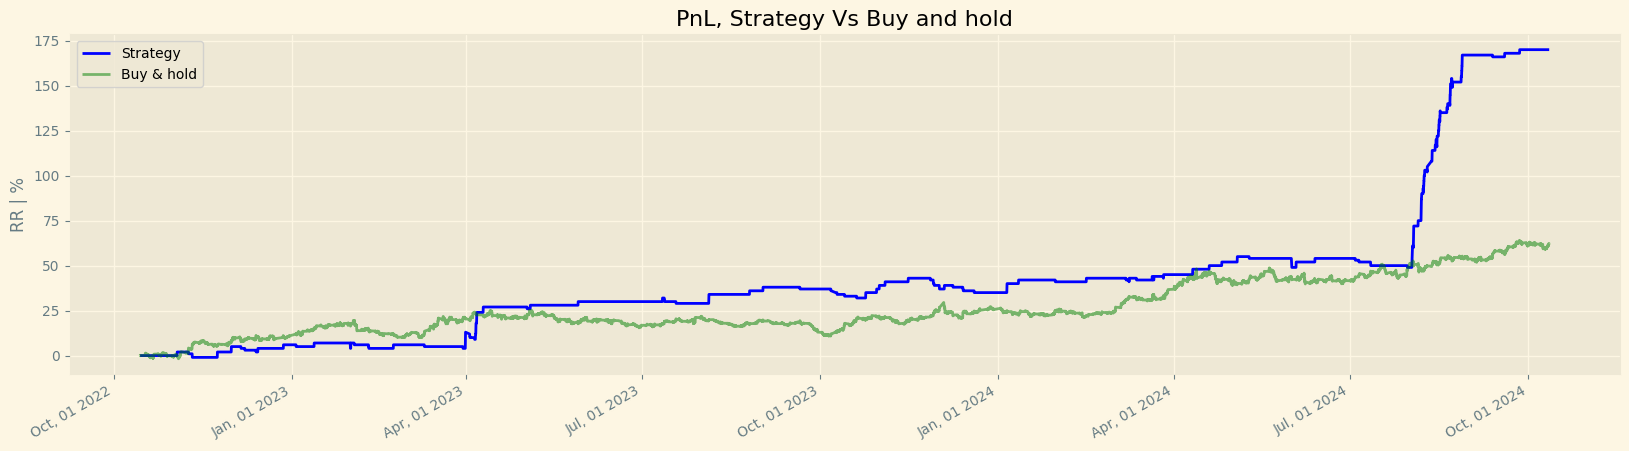

In [24]:
starting_inv_price = df['Close'].iloc[0]

# Plot the Strategy returns
df['Cumulative_PnL'].plot(
        label='Strategy', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='blue', 
        xlabel='',
        ylabel='RR | %'
    )

(100 * (df['Close'] - starting_inv_price)/starting_inv_price).plot(
        label='Buy & hold', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='green', 
        xlabel='',
        alpha=.5,
        ylabel='RR | %'
    )

plt.title('PnL, Strategy Vs Buy and hold')
plt.legend()

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

- **PnL-Drawdown** (not from Equity)

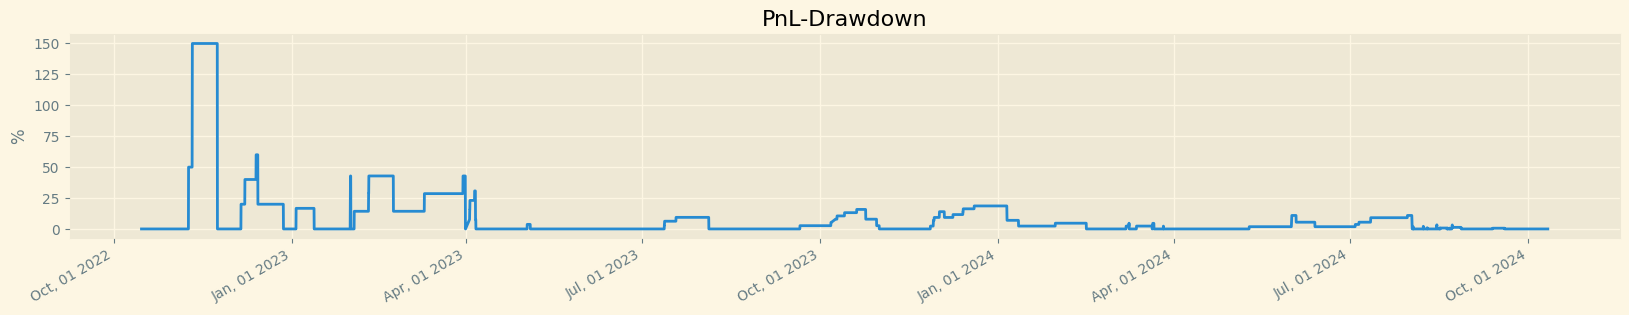

In [25]:
df['Peak'] = df['Cumulative_PnL'].cummax()

# df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / abs(df['Peak'])
df['Drawdown'] = np.where(df['Peak'] == 0, abs(df['Cumulative_PnL']), (df['Peak'] - df['Cumulative_PnL']) / df['Peak'])

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)
# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2),
    title="PnL-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

In [26]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 150.0 %


# **5. Overview on positions**

Text(0.5, 1.0, 'Positions nature')

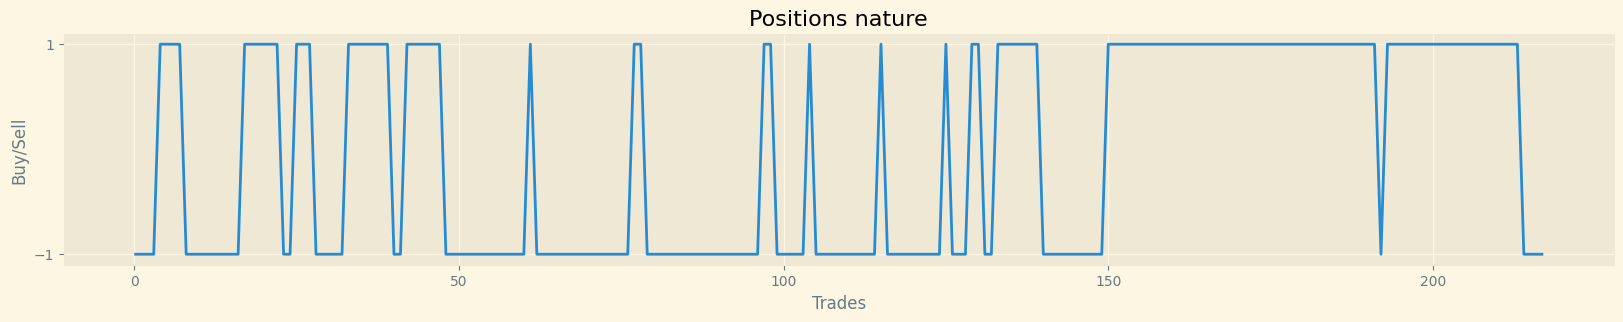

In [27]:
positions = df.loc[df['Position'] != 0, 'Position'].values 

pd.Series(positions).plot(
    figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2), 
    yticks=[-1, 1],
    ylabel='Buy/Sell',
    xlabel='Trades'
)

plt.title('Positions nature')

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

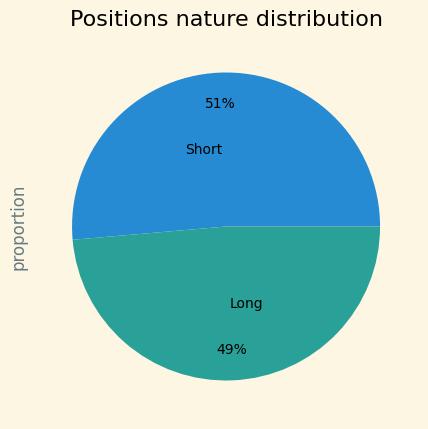

In [28]:
positions_nature_distribution_df = df.loc[df['Position'] != 0, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

<Axes: title={'center': 'Percentage of Long & Short from losing positions'}, ylabel='proportion'>

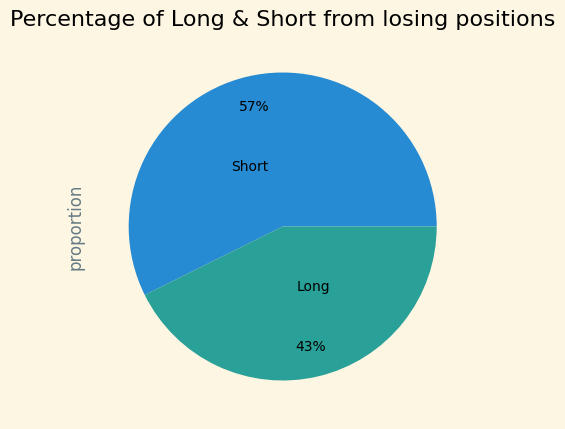

In [29]:
losing_positions_sr = df.loc[df['PnL'] == -1, 'Position'].value_counts(normalize=True)

losing_positions_sr.index = [POSITIONS_NATURE[str(x)] for x in losing_positions_sr.index.to_list()]

losing_positions_sr.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Percentage of Long & Short from losing positions",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.4
)

In [30]:
# [TODO] max consecutive wins & losses (so we can avoid drawdown)

# **6. A study on Drawdown**